In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.340

Firmware configuration (built Wed Sep  6 18:49:29 2023):

	Global clocks (MHz): tProc dispatcher timing 409.600, RF reference 491.520
	Groups of related clocks: [tProc clock, DAC tile 0], [DAC tile 2], [ADC tile 0]

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 Msps, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 Msps, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 Msps, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		axis_avg_buffer v1.0 (no edge counter, no weights)
		memory 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PY

In [7]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        
        
        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        
        # Set waveform
        self.add_envelope(ch=cfg["res_ch"], name = cfg["pulse_name"], idata=np.linspace(0,32766,16*60),qdata=np.zeros(16*60))
        # self.add_gauss(ch=cfg["res_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        
        self.add_envelope(ch=cfg["res_ch"], name = "const", idata=32766*np.ones(16*60),qdata=np.zeros(16*60))
        
        self.default_pulse_registers(ch=cfg["res_ch"], style="arb", freq=freq, phase=0, gain=cfg["pulse_gain"])
        self.set_pulse_registers(ch=cfg["res_ch"],waveform=cfg["pulse_name"])
        
        # Set threshold
        self.regwi(0,1,self.cfg["threshold"])

        # Set value of number 
        self.regwi(0,2,self.cfg["number"])
        
        # Set const pulse number
        self.regwi(0,3,cfg["const_pulses"]-1)
        
        

        # self.synci(200)  # give processor some time to configure pulses
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.trigger(adcs=[self.cfg["ro_ch"]],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'<',1,'LABEL') 
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse
        self.set_pulse_registers(ch=self.cfg["res_ch"],waveform="const")
        self.label('LOOP_CONST')
        self.pulse(ch=self.cfg["res_ch"]) 
        # self.mathi(0, 3, 3, '-', 1)
        # self.condj(0, 3, '>=', 4, 'LOOP_CONST')
        self.loopnz(0,3,'LOOP_CONST')
        self.label('LABEL')
        # self.pulse(ch=self.cfg["res_ch"]) 
        # control should wait until the readout is over
        self.wait_all() 

        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [8]:
config={"res_ch":1, # --Fixed
        "ro_ch":1, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":50, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":3000, # [DAC units]
        "pulse_freq": 2000, # [MHz]
        "adc_trig_offset": 110, # [Clock ticks]
        "soft_avgs":1000,
        ### New variables
        "number": 100,
        "threshold": 50,
        "pulse_name": "ramping_up",
        "sigma":1,
        "const_pulses":5
       }

prog =LoopbackProgram(soccfg, config)
print(prog)
(iq0,) = prog.acquire_decimated(soc, progress=True)


// Program

            regwi 1, $22, 873813330;            //freq = 873813330
            regwi 1, $23, 0;                    //phase = 0
            regwi 1, $25, 3000;                 //gain = 3000
            regwi 1, $24, 0;                    //addr = 0
            regwi 1, $26, 524348;               //phrst| stdysel | mode | | outsel = 0b01000 | length = 60 
            regwi 0, $1, 50;
            regwi 0, $2, 100;
            regwi 0, $3, 4;
            synci 204800;
            regwi 0, $15, 0;
            regwi 0, $14, 0;
LOOP_J:     regwi 0, $16, 32768;                //out = 0b1000000000000000
            seti 7, 0, $16, 110;                //ch =0 out = $16 @t = 0
            seti 7, 0, $0, 120;                 //ch =0 out = 0 @t = 0
            condj 0, $2, <, $1, @LABEL;
            regwi 1, $27, 0;                    //t = 0
            set 1, 1, $22, $23, $24, $25, $26, $27;//ch = 1, pulse @t = $27
            regwi 1, $24, 60;                   //addr = 60
         

  0%|          | 0/1000 [00:00<?, ?it/s]

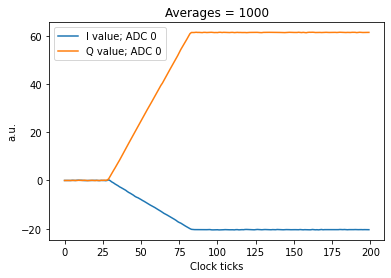

In [9]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0].flatten(), label="I value; ADC 0")
plt.plot(iq0[1].flatten(), label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Conditional_False_Pulse.pdf", dpi=350)

In [6]:
zeros

<function numpy.zeros>

In [381]:
?prog.loopnz

Signature: prog.loopnz(*args)
Docstring: <no docstring>
File:      /home/xilinx/jupyter_notebooks/qick/qick_lib/qick/asm_v1.py
Type:      function


In [172]:
np.linspace(0,100,16*100)

array([0.00000000e+00, 6.25390869e-02, 1.25078174e-01, ...,
       9.98749218e+01, 9.99374609e+01, 1.00000000e+02])

In [189]:
prog.cycles2us(1)

0.00244140625

In [262]:
2**16

65536

In [342]:
?AveragerProgram

Init signature: AveragerProgram(soccfg, cfg)
Docstring:     
AveragerProgram class is an abstract base class for programs which do loops over experiments in hardware.
It consists of a template program which takes care of the loop and acquire methods that talk to the processor to stream single shot data in real-time and then reshape and average it appropriately.

:param soccfg: This can be either a QickSoc object (if the program is running on the QICK) or a QickCOnfig (if running remotely).
:type soccfg: QickConfig
:param cfg: Configuration dictionary
:type cfg: dict
Init docstring:
Constructor for the AveragerProgram, calls make program at the end.
For classes that inherit from this, if you want it to do something before the program is made and compiled:
either do it before calling this __init__ or put it in the initialize method.
File:           /home/xilinx/jupyter_notebooks/qick/qick_lib/qick/averager_program.py
Type:           ABCMeta
Subclasses:     LoopbackProgram, LoopbackProgra